In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**IMPORT NECESSARY LIBRARIES**

In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.lite.python import interpreter as interpreter_wrapper
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

**MODEL TRAINING**

In [ ]:
# Extract the data from the zip file
with zipfile.ZipFile('/content/drive/MyDrive/fruits-fresh-rotten-classification-master.zip', 'r') as zip_ref:
    zip_ref.extractall('Fruit-Classification')



In [ ]:


# Define paths to the training data
train_dir = '/content/Fruit-Classification/fruits-fresh-rotten-classification-master/Datasets/train'

# Create an image data generator
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_data_generator.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Set target size to 224x224
    batch_size=32,
    class_mode='categorical'  # Use categorical labels
)

# Build the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')  # Set output neurons to 6 for six classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    verbose=1
)

# Save the trained model
model.save('Fruit-Classification.h5')   # Save model with softmax activation and six output neurons


Found 10901 images belonging to 6 classes.
Epoch 1/20
341/341 [==============================] - 1708s 5s/step - loss: 0.8116 - accuracy: 0.7198
Epoch 2/20
341/341 [==============================] - 1703s 5s/step - loss: 0.3827 - accuracy: 0.8645
Epoch 3/20
341/341 [==============================] - 1730s 5s/step - loss: 0.3020 - accuracy: 0.8870
Epoch 4/20
341/341 [==============================] - 1706s 5s/step - loss: 0.2387 - accuracy: 0.9113
Epoch 5/20
341/341 [==============================] - 1710s 5s/step - loss: 0.1938 - accuracy: 0.9262
Epoch 6/20
341/341 [==============================] - 1698s 5s/step - loss: 0.1777 - accuracy: 0.9339
Epoch 7/20
341/341 [==============================] - 1713s 5s/step - loss: 0.1829 - accuracy: 0.9295
Epoch 8/20
341/341 [==============================] - 1693s 5s/step - loss: 0.1418 - accuracy: 0.9485
Epoch 9/20
341/341 [==============================] - 1648s 5s/step - loss: 0.1398 - accuracy: 0.9477
Epoch 10/20
341/341 [==================

**QUANTIZE AND CONVERT TO TFLITE**

In [ ]:

# Load the trained model
loaded_model = tf.keras.models.load_model('/content/Fruit-Classification.h5')

# Convert the model to a TFLite quantized model
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Apply optimizations including quantization
quantized_tflite_model = converter.convert()

# Save the quantized TFLite model to a file
with open('/content/Fruit-Classification.tflite', 'wb') as f:
    f.write(quantized_tflite_model)


**TESTING**

Class names: ['0 freshapples', '1 freshbanana', '2 freshoranges', '3 rottenapples', '4 rottenbanana', '5 rottenoranges']
Contents of the test directory: ['.ipynb_checkpoints', '0 freshapples', '1 freshbanana', '5 rottenoranges', '3 rottenapples', '4 rottenbanana', '2 freshoranges']
Accuracy: 75.43%


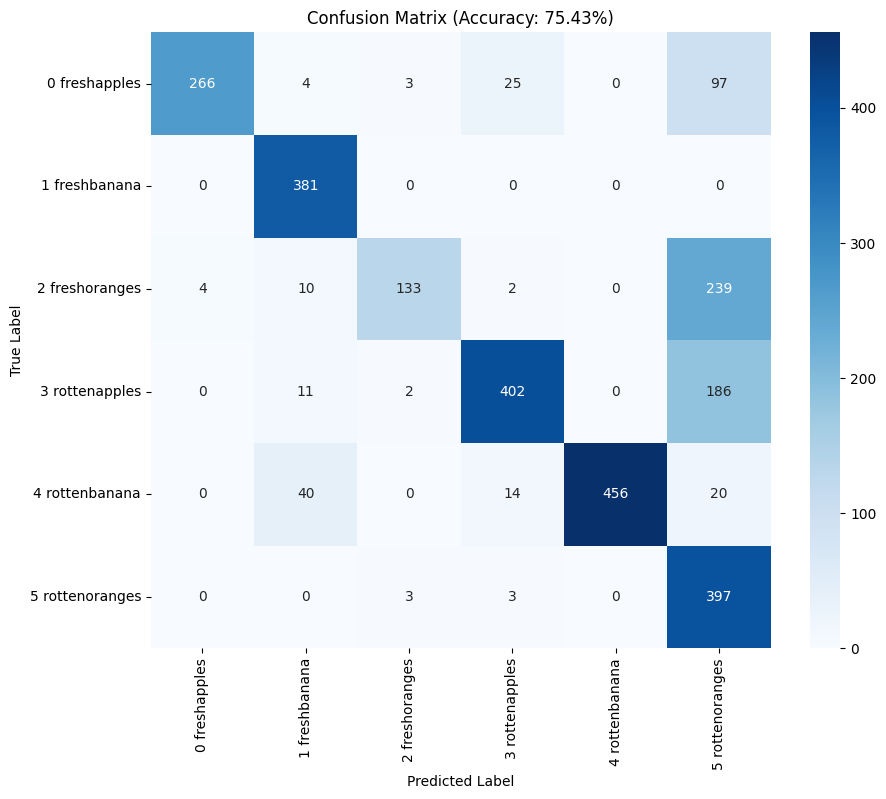

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing import image

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path="/content/model_unquant.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Define the directory path to the test data
test_data_dir = '/content/Fruit-Classification/fruits-fresh-rotten-classification-master/Datasets/test'

# Load class names from a text file
class_names_file = '/content/labels.txt'
with open(class_names_file, 'r') as file:
    class_names = file.read().splitlines()

# Print the loaded class names for debugging
print(f"Class names: {class_names}")

# Check available directories in the test_data_dir for debugging
print(f"Contents of the test directory: {os.listdir(test_data_dir)}")

# Initialize variables to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over each class (folder) in the test data directory
for class_name in class_names:
    class_dir = os.path.join(test_data_dir, class_name)

    if not os.path.exists(class_dir):
        print(f"Directory does not exist: {class_dir}")
        continue

    for filename in os.listdir(class_dir):
        # Process only image files (assuming typical image extensions)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            # Load and preprocess the test image
            img_path = os.path.join(class_dir, filename)
            try:
                img = image.load_img(img_path, target_size=(224, 224))
                img_array = image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                img_array = img_array / 255.0  # Normalize pixel values
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                continue

            # Set input tensor
            interpreter.set_tensor(input_details[0]['index'], img_array)

            # Run inference
            interpreter.invoke()

            # Get output tensor
            predictions = interpreter.get_tensor(output_details[0]['index'])

            # Get the predicted class index
            predicted_class_index = np.argmax(predictions)

            # Append true and predicted labels
            true_labels.append(class_name)
            predicted_labels.append(class_names[predicted_class_index])

# Ensure there are labels to calculate accuracy
if true_labels and predicted_labels:
    # Calculate accuracy
    accuracy = np.mean(np.array(true_labels) == np.array(predicted_labels)) * 100
    print(f"Accuracy: {accuracy:.2f}%")

    # Generate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Accuracy: {:.2f}%)'.format(accuracy))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
else:
    print("No labels to calculate accuracy. Please check the test data.")


**SINGLE IMAGE PREDICTION**

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path="/content/model_unquant.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load class names from a text file
class_names_file = '/content/labels.txt'
with open(class_names_file, 'r') as file:
    class_names = file.read().splitlines()

# Function to predict the class of a single image
def predict_single_image(img_path):
    try:
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0  # Normalize pixel values

        # Set input tensor
        interpreter.set_tensor(input_details[0]['index'], img_array)

        # Run inference
        interpreter.invoke()

        # Get output tensor
        predictions = interpreter.get_tensor(output_details[0]['index'])

        # Get the predicted class index
        predicted_class_index = np.argmax(predictions)

        # Get the class name
        predicted_class_name = class_names[predicted_class_index]

        return predicted_class_name
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")
        return None

# Example usage of the function
test_image_path = '/content/RottenBannana.jpg'  # Replace with your test image path
predicted_class = predict_single_image(test_image_path)
if predicted_class:
    print(f"The predicted class for the image is: {predicted_class}")
else:
    print("Failed to predict the class for the image.")


The predicted class for the image is: 4 rottenbanana
